# Demonstração do código vetorizado para o sistema de 14 barras

In [1]:
#Se estiver rodando no Colab, descomente e execute as linhas a seguir:

#!pip install pandapower
#!pip install tabulate

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LeonardoCampos-EE/FPOR_GWO/blob/master/FPORdiscreto_GWO_Demo.ipynb)

# Importando as bibliotecas necessárias

In [2]:
import numpy as np
import time
import copy
import pandapower as pp
from pandapower.networks import case14, case_ieee30

np.set_printoptions(precision = 3, suppress = True)

rede = case14()

#Executar o fluxo de carga uma primeira vez acelera os cálculos posteriores
pp.runpp(rede, algorithm = 'nr', numba = True)

# Funções auxiliares

Lista de funções:

* discreto_superior(vetor\_x, lista\_discretos)

    Exemplo 1:
      Entrada:
        vetor_x = [0.0, 0.15, 0.30, 0.39]
        lista_discretos = [0.0, 0.19, 0.34, 0.39]

      Saída:
        x_sup = [0.19, 0.19, 0.34, 0.39]

    Exemplo 2:
       Entrada:
        vetor_x = [1.0, 1.5, 2.1, 3.0, 4.0, 4.5]
        lista_discretos = [0.0, 2.0, 3.5, 4.5] 
        
      Saída:
        x_sup = [2.0, 2.0, 3.5, 3.5, 4.5, 4.5]

* discreto_inferior(vetor\_x, lista\_discretos)

    Exemplo 1:
      Entrada:
        vetor_x = [0.0, 0.15, 0.30, 0.39]
        lista_discretos = [0.0, 0.19, 0.34, 0.39]

      Saída:
        x_sup = [0.0, 0.0, 0.19, 0.34]

    Exemplo 2:
       Entrada:
        vetor_x = [1.0, 1.5, 2.1, 3.0, 4.0, 4.5]
        lista_discretos = [0.0, 2.0, 3.5, 4.5] 
        
      Saída:
        x_sup = [0.0, 0.0, 2.0, 2.0, 3.5, 3.5]


In [3]:
def discreto_superior(vetor_x, lista_discretos):
    '''
    Função que retorna o valor discreto superior de 'lista_discretos' mais próximo de todos os valores x de 'vetor_x' 

    Inputs:
        -> vetor_x = vetor (numpy array) contendo os valores que deseja-se obter o número discreto mais próximos
        -> lista_discretos = lista (python list) que contém o conjunto de valores discretos que cada variável x admite
    
    Ouputs:
        -> x_sup = vetor (numpy array) contendo os valores discretos superiores de 'lista_discretos' mais próximo 
           dos valores de 'vetor_x'
    '''
    #Vetor de saída da função. Possui o mesmo formato (shape) que vetor_x
    x_sup = np.zeros(vetor_x.shape)
    
    #Cópia de 'vetor_x'. Esta cópia é feita para evitar erros de alocamento dinâmico de memória.
    vetor = np.copy(vetor_x)
    
    #Garante que a lista seja uma array numpy e armazena o resultado na variável 'lista'
    lista = np.asarray(lista_discretos, dtype = np.float32)
    
    '''
    Garante que os valores de 'vetor_x' estejam dentro dos limites de 'lista discretos' por um pequeno fator de 10^-3.
    Caso contrário, a função numpy.searchsorted descrita a frente resultará em erro.
    '''
    vetor = vetor - 1e-3
    np.clip(a = vetor, a_min = lista[0] + 1e-3, a_max = lista[-1] - 1e-3, out = vetor)
    
    '''
    Utilizando a função numpy.searchsorted() para buscar os índices de 'lista_discretos' que correspondem aos valores
    discretos superiores aos valores de 'vetor_x'
    '''
    indices = np.searchsorted(a=lista, v = vetor, side='right')
    
    #Armazena os valores de 'lista_discretos' cujos índices correspondem aos discretos superiores de 'vetor_x'
    x_sup = np.take(lista, indices)
    
    #Deleta as variáveis locais
    del vetor, lista, indices
    
    return x_sup

In [4]:
'''
Teste de discreto_superior
'''
vetor_teste = np.array([0., 0.15, 0.19, 0.30, 0.34, 0.37, 0.39])
lista_teste = np.array([0, 0.19, 0.34, 0.39])

print('Vetor_teste = {}'.format(vetor_teste))
print('x_sup = {}'.format(discreto_superior(vetor_teste, lista_teste)))

Vetor_teste = [0.   0.15 0.19 0.3  0.34 0.37 0.39]
x_sup = [0.19 0.19 0.19 0.34 0.34 0.39 0.39]


Resultado esperado:

    x_sup = [0.19, 0.19, 0.19, 0.34, 0.34, 0.39, 0.39]


In [5]:
def discreto_inferior(vetor_x, lista_discretos):
    '''
    Função que retorna o valor discreto inferior de 'lista_discretos' mais próximo de todos os valores x de 'vetor_x' 
    
    Inputs:
        -> vetor_x = vetor (numpy array) contendo os valores que deseja-se obter o número discreto mais próximo
        -> lista_discretos = lista (python list) que contém o conjunto de valores discretos que cada variável x admite
    
    Ouputs:
        -> x_inf = vetor (numpy array) contendo os valores discretos inferiores de 'lista_discretos' mais próximos 
           dos valores de 'vetor_x'
    '''
    
    #Vetor de saída da função. Possui o mesmo formato (shape) que vetor_x
    x_inf = np.zeros(vetor_x.shape)
    
    #Cópia de 'vetor_x'. Esta cópia é feita para evitar erros de alocamento dinâmico de memória.
    vetor = np.copy(vetor_x)
    
    #Garante que a lista seja uma array numpy e salva o resultado na variável local 'lista'
    lista = np.asarray(lista_discretos, dtype = np.float32)
    
    '''
    Garante que os valores de 'vetor_x' estejam dentro dos limites de 'lista discretos' por um pequeno fator de 10^-3.
    Caso contrário, a função numpy.searchsorted descrita a frente resultará em erro. Salva o resultado de numpy.clip
    na variável local 'vetor'
    '''
    vetor = vetor - 1e-3
    np.clip(a = vetor, a_min = lista_discretos[0] + 1e-3, a_max = lista_discretos[-1] - 1e-3, out = vetor)
    
    '''
    Utilizando a função numpy.searchsorted() para buscar os índices de 'lista_discretos' que correspondem aos valores
    discretos inferiores aos valores de 'vetor_x'
    '''
    indices = np.searchsorted(a=lista, v = vetor, side='left') - 1
    
    #Armazena os valores de 'lista_discretos' cujos índices correspondem aos discretos superiores de 'vetor_x'
    x_inf = np.take(lista, indices)
    
    #Deleta as variáveis locais
    del vetor, lista, indices
    
    return x_inf

In [6]:
'''
Teste de discreto_inferior
'''
vetor_teste = np.array([0., 0.15, 0.19, 0.30, 0.34, 0.37, 0.39])
lista_teste = [0., 0.19, 0.34, 0.39]

print('Vetor_teste = {}'.format(vetor_teste))
print('x_inf = {}'.format(discreto_inferior(vetor_teste, lista_teste)))

Vetor_teste = [0.   0.15 0.19 0.3  0.34 0.37 0.39]
x_inf = [0.   0.   0.   0.19 0.19 0.34 0.34]


Resultado esperado:

    x_inf = [0.0, 0.0, 0.0, 0.19, 0.19, 0,34, 0.34]

In [7]:
'''
Teste d
'''
vetor_teste = np.array([0., 0.15, 0.19, 0.30, 0.34, 0.37, 0.39])
lista_teste = [0., 0.19, 0.34, 0.39]

d = discreto_superior(vetor_teste, lista_teste) - discreto_inferior(vetor_teste, lista_teste)
print('d = {}'.format(d))

d = [0.19 0.19 0.19 0.15 0.15 0.05 0.05]


Resultado esperado:

    d = [0.19, 0.19, 0.19, 0.15, 0.15, 0.05, 0.05]

# Gerenciamento da rede

In [8]:
def gerenciar_rede(rede):
    
    """
    Esta funcao organiza a rede obtida do PandaPower de modo que ela possa ser mais facilmente utilizada pelo algoritmo.
    Suas funcionalidades são:
        
        -> Ordenar os parâmetros da rede (v_bus, tap, shunt, etc) por índices;
        -> Obter os transformadores com controle de tap;
        -> Gerar o vetor com os valores dos taps dos transformadores;
        -> Gerar as matrizes com os valores discretos para os shunts de cada sistema;
        -> Gerar as matrizes de mascaramento com as probabilidades de escolha dos shunts para cada sistema;
        -> Gerar o primeiro agente de busca (que contém as variáveis do ponto de operação do sistema);
        -> Obter as condutâncias das linhas.
        
    Input:
        -> rede
        
    Output:
        
        -> rede gerenciada (não devolvida, salva diretamente na variável rede);
        -> primeiro agente de buscas: lobo_1;
        -> vetor de condutâncias da rede: G_rede;
        -> matriz das linhas de transmissao: linhas;
        -> vetor contendo os valores discretos para os taps: valores_taps;
        -> matrizes contendo os valores discretos para os shunts: valores_shunts;
        -> matrizes de mascaramento dos shunts: mask_shunts.
    """
    
    #Ordenar os índices da rede
    rede.bus = rede.bus.sort_index()
    rede.res_bus = rede.res_bus.sort_index()
    rede.gen = rede.gen.sort_index()
    rede.line = rede.line.sort_index()
    rede.shunt = rede.shunt.sort_index()
    rede.trafo = rede.trafo.sort_index()

    #Algumas redes são inicializadas com taps negativos
    rede.trafo.tap_pos = np.abs(rede.trafo.tap_pos)

    #É preciso ordenar os taps para remover os transformadores sem controle de tap
    rede.trafo = rede.trafo.sort_values('tap_pos')

    #num_trafo_controlado: variavel para armazenar o número de trafos com controle de tap
    num_trafo_controlado = rede.trafo.tap_pos.count()
    
    #num_barras : variavel utilizada para salvar o numero de barras do sistema
    num_barras = rede.bus.name.count()
    
    #num_shunt: variavel para armazenar o numero de shunts do sistema
    num_shunt = rede.shunt.in_service.count()
    
    #num_gen: variavel para armazenar o número de barras geradoras do sistema
    num_gen = rede.gen.in_service.count()
    
    '''
    Cria as varíaveis globais nb, nt, ns, ng para facilitar o uso desses parâmetros em outros funções
    
    '''
    global nb, nt, ns, ng
    nb, nt, ns, ng = num_barras, num_trafo_controlado, num_shunt, num_gen
    
    '''
    Muda os valores máximos e mínimos permitidos das tensões das barras dos sistemas de 118 e 300 barras:
        min_vm_pu: 0.94 -> 0.90
        max_vm_pu: 1.06 -> 1.10
    '''
    if nb == 118 or nb == 300:
        rede.bus.min_vm_pu = 0.90
        rede.bus.max_vm_pu = 1.10
    
    #Dicionário que contem os valores dos shunts para cada sistema IEEE
    valores_shunts = {"14": np.array([
                            [0.0, 0.19, 0.34, 0.39]
                            ]),
                      
                      "30": np.array([
                            [0.0, 0.19, 0.34, 0.39],
                            [0.0, 0.0, 0.05, 0.09]
                            ]),
                      
                      "57": np.array([
                            [0.0, 0.12, 0.22, 0.27], 
                            [0.0, 0.04, 0.07, 0.09], 
                            [0.0, 0.0, 0.10, 0.165]
                            ]),
                      
                      "118": np.array([
                              [-0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.06, 0.07, 0.13, 0.14, 0.2],
                              [-0.25, 0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0, 0.1],
                              [0.0, 0.0, 0.0, 0.0, 0.0, 0.1],
                              [0.0, 0.0, 0.0, 0.0, 0.0, 0.1],
                              [0.0, 0.0, 0.0, 0.0, 0.0, 0.15],
                              [0.0, 0.0, 0.0, 0.08, 0.12, 0.2],
                              [0.0, 0.0, 0.0, 0.0, 0.1, 0.2],
                              [0.0, 0.0, 0.0, 0.0, 0.1, 0.2],
                              [0.0, 0.0, 0.0, 0.0, 0.1, 0.2],
                              [0.0, 0.0, 0.0, 0.0, 0.1, 0.2],
                              [0.0, 0.06, 0.07, 0.13, 0.14, 0.2],
                              [0.0, 0.06, 0.07, 0.13, 0.14, 0.2]
                              ]),
                      
                      "300": np.array([
                              [0.0, 2.0, 3.5, 4.5],
                              [0.0, 0.25, 0.44, 0.59],
                              [0.0, 0.19, 0.34, 0.39],
                              [-4.5, 0.0, 0.0, 0.0],
                              [-4.5, 0.0, 0.0, 0.0],
                              [0.0, 0.25, 0.44, 0.59],
                              [0.0, 0.25, 0.44, 0.59],
                              [-2.5, 0.0, 0.0, 0.0],
                              [-4.5, 0.0, 0.0, 0.0],
                              [-4.5, 0.0, 0.0, 0.0],
                              [-1.5, 0.0, 0.0, 0.0],
                              [0.0, 0.25, 0.44, 0.59],
                              [0.0, 0.0, 0.0, 0.15],
                              [0.0, 0.0, 0.0, 0.15]
                              ])
                      }
    
    mask_shunts = {
        '14': np.array([
              [0.25, 0.25, 0.25, 0.25]
        ]),
        '30': np.array([
              [0.25, 0.25, 0.25, 0.25],
              [0.0, 1./3., 1./3., 1./3.]
              ]),
        '57': np.array([
              [0.25, 0.25, 0.25, 0.25], 
              [0.25, 0.25, 0.25, 0.25], 
              [0.0, 1./3., 1./3., 1./3.]
              ]),
        '118': np.array([
              [0.5, 0.5, 0.0, 0.0, 0.0, 0.0],
              [1./6., 1./6., 1./6., 1./6., 1./6., 1./6.],
              [0.5, 0.5, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.5, 0.5],
              [0.0, 0.0, 0.0, 0.0, 0.5, 0.5],
              [0.0, 0.0, 0.0, 0.0, 0.5, 0.5],
              [0.0, 0.0, 0.0, 0.0, 0.5, 0.5],
              [0.0, 0.0, 0.25, 0.25, 0.25, 0.25],
              [0.0, 0.0, 0.0, 1./3., 1./3., 1./3.],
              [0.0, 0.0, 0.0, 1./3., 1./3., 1./3.],
              [0.0, 0.0, 0.0, 1./3., 1./3., 1./3.],
              [0.0, 0.0, 0.0, 1./3., 1./3., 1./3.],
              [1./6., 1./6., 1./6., 1./6., 1./6., 1./6.],
              [1./6., 1./6., 1./6., 1./6., 1./6., 1./6.]
              ]),
        '300': np.array([
              [0.25, 0.25, 0.25, 0.25],
              [0.25, 0.25, 0.25, 0.25],
              [0.25, 0.25, 0.25, 0.25],
              [0.5, 0.5, 0.0, 0.0],
              [0.5, 0.5, 0.0, 0.0],
              [0.25, 0.25, 0.25, 0.25],
              [0.25, 0.25, 0.25, 0.25],
              [0.5, 0.5, 0.0, 0.0],
              [0.5, 0.5, 0.0, 0.0],
              [0.5, 0.5, 0.0, 0.0],
              [0.5, 0.5, 0.0, 0.0],
              [0.25, 0.25, 0.25, 0.25],
              [0.0, 0.0, 0.5, 0.5],
              [0.0, 0.0, 0.5, 0.5]
              ])
    }

    
    
    #Vetor que contém os valores discretos dos taps: entre 0.9 e 1.1 com passo = tap_step
    #Precisa ser um tensor de rank 1 para que a alcateia possa ser inicializada
    global tap_step
    tap_step = 0.00625
    valores_taps = np.arange(start = 0.9, stop = 1.1, step = tap_step)
    
    """
    Matriz contendo as linhas de transmissão da rede:
        -> linhas[0] = vetor com as barras de ínicio;
        -> linhas[1] = vetor com as barras de términa;
        -> linhas[2] = vetor com as resistências em pu (r_pu) das linhas;
        -> linhas[3] = vetor com as reatâncias em pu (x_pu) das linhas.
    r_pu = r_ohm/z_base
    x_pu = x_ohm/z_base
    g = r_pu/(r_pu^2 + x_pu^2)
    """
    
    linhas = np.zeros((4, rede.line.index[-1]+1))
    linhas[0] = rede.line.from_bus.to_numpy()
    linhas[1] = rede.line.to_bus.to_numpy()
    v_temp = rede.bus.vn_kv.to_numpy()
    z_base = np.power(np.multiply(v_temp,1000), 2)/100e6
    for i in range(rede.line.index[-1]+1):
        linhas[2][i] = rede.line.r_ohm_per_km[i]/z_base[int(linhas[0][i])]
        linhas[3][i] = rede.line.x_ohm_per_km[i]/z_base[int(linhas[0][i])]
    del v_temp, z_base
    
    #Vetor G_rede com as condutâncias das linhas de transmissão
    G_rede = np.zeros((1, rede.line.index[-1]+1))
    G_rede = np.array([np.divide(linhas[2], np.power(linhas[2],2)+np.power(linhas[3],2))])
    
    #Matriz de condutância nodal da rede. É equivalente à parte real da matriz de admintância nodal do sistema
    matriz_G = np.zeros((num_barras,num_barras))
    matriz_G[linhas[0].astype(np.int), linhas[1].astype(np.int)] = G_rede 
    
    """
    O primeiro lobo (agente de busca) será inicializado com os valores de operação da rede fornecidos
    pelo PandaPower: vetor lobo_1.
    
    tap_pu = (tap_pos + tap_neutral)*tap_step_percent/100 (equação fornecida pelo PandaPower)
    shunt_pu = -100*shunt (equação fornecida pelo PandaPower)
    
    As variáveis v_temp, taps_temp e shunt_temp são utilizadas para receber os valores de tensão, tap e shunt da rede
    e armazenar no vetor lobo_1
    """
    
    v_temp = rede.gen.vm_pu.to_numpy(dtype = np.float32)
    
    taps_temp = 1 + ((rede.trafo.tap_pos.to_numpy(dtype = np.float32)[0:num_trafo_controlado] +\
                      rede.trafo.tap_neutral.to_numpy(dtype = np.float32)[0:num_trafo_controlado]) *\
                     (rede.trafo.tap_step_percent.to_numpy(dtype = np.float32)[0:num_trafo_controlado]/100))
        
    shunt_temp = -rede.shunt.q_mvar.to_numpy(dtype = np.float32)/100
    
    lobo_1 = np.array([np.concatenate((v_temp, taps_temp, shunt_temp),axis=0)])
    del v_temp, taps_temp, shunt_temp
    
    parametros_rede = {"Linhas": linhas,
                       "Lobo1": lobo_1,
                       "Valores_shunts": valores_shunts,
                       "Valores_taps": valores_taps,
                       "Mask_shunts": mask_shunts,
                       "matriz_G": matriz_G}

    return parametros_rede

In [9]:
'''
Teste de gerenciar_rede()
'''

parametros_rede = gerenciar_rede(rede)

conjunto_shunts = parametros_rede["Valores_shunts"][str(nb)]
print('O conjunto de valores discretos permitido para o shunt é: {}'.format(conjunto_shunts))

O conjunto de valores discretos permitido para o shunt é: [[0.   0.19 0.34 0.39]]


In [10]:
rede.trafo

,df,hv_bus,i0_percent,in_service,lv_bus,max_loading_percent,name,parallel,pfe_kw,shift_degree,...,tap_min,tap_phase_shifter,tap_pos,tap_side,tap_step_degree,tap_step_percent,vn_hv_kv,vn_lv_kv,vk_percent,vkr_percent
0,1.0,3,0.0,True,6,100.0,None,1,0.0,0.0,...,NaN,False,1.0,hv,NaN,2.2,135.0,14.000,2070.288,0.0
1,1.0,3,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,1.0,hv,NaN,3.1,135.0,0.208,5506.182,0.0
2,1.0,4,0.0,True,5,100.0,None,1,0.0,0.0,...,NaN,False,1.0,hv,NaN,6.8,135.0,0.208,2494.998,0.0
3,1.0,6,0.0,True,7,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,12.000,1743.885,0.0
4,1.0,6,0.0,True,8,100.0,None,1,0.0,0.0,...,NaN,False,NaN,None,NaN,NaN,14.0,0.208,1089.099,0.0


Resultado esperado:

    Conjunto_shunts = [[0.0, 0.19, 0.34, 0.39]]

# Inicializando a Alcateia

A Alcateia de lobos (agentes de busca - representados pela letra w) pode ser representada como uma matriz (numpy array) de dimensão (d+5, n). Em que d é o número de variáveis do problema de otimização e n é o número de lobos definido. O elemento $w_{ij}$ representa a j-ésima coordenada (variável do problema) do i-ésimo lobo.

Assim sendo, cada lobo é uma coluna da matriz. De forma que as linhas d a d+4 representam, em sequência: a função objetivo calculada para cada lobo; a função de penalização senoidal dos taps calculada para cada lobo; a função de penalização senoidal para os shunts calculada para cada lobo. As definições destas funções na próxima seção deste notebook.

A matriz pode então ser representada por:

\begin{bmatrix}
    w_{11} & w_{12} & ... & w_{1n}\\ 
    w_{21} & w_{22} & ... & w_{2n}\\ 
    \vdots  & \vdots  & \ddots  & \vdots \\ 
    w_{d1} & w_{d2} & ... & w_{dn}\\ 
    f_1 & f_2 & ... & f_n\\ 
    P_V(V_{B_{CR}})_1 & P_V(V_{B_{CR}})_2 & ... & P_V(V_{B_{CR}})_n\\
    P_{sen}(t)_1 & P_{sen}(t)_2 & ... & P_{sen}(t)_n\\ 
    P_{sen}(b^{sh})_1 & P_{sen}(b^{sh})_2 & ... & P_{sen}(b^{sh})_n\\ 
    fitness_1 & fitness_2 & ... & fitness_n
\end{bmatrix}


In [11]:
def inicializar_alcateia(n_lobos, rede, parametros_rede):
    '''
    Esta função inicializa a alcateia de lobos (agentes de busca) como uma matriz (numpy array) com formato (dim+5, n_lobos)
    
        -> Cada coluna da matriz representa um lobo.
        -> As linhas de 0 a dim-1 são as variáveis do problema.
        -> A linha dim armazena a função objetivo para cada lobo;
        -> A linha dim+1 armazena a penalidade das tensões para cada lobo;
        -> A linha dim+2 armazena a penalidade dos taps para cada lobo;
        -> A linha dim+3 armazena a penalidade dos shunts para cada lobo;  
        -> A linha dim+4 armazena a função fitness para cada lobo;
        
        
    Inputs:
        -> n_lobos = número de agentes de busca;
        -> rede
        -> parametros_rede - obtido via função gerenciar_rede
    
    Output:
        -> Alcateia
    '''
    
    '''
    Variável que armazena o número de variáveis do problema.
    ng = número de barras geradoras do sistema;
    nt = número de transformadores com controle de tap do sistema;
    ns = número de susceptâncias shunt do sistema.
    '''
    dim = ng + nt+ ns
    
    #Inicialização da Alcateia com zeros
    alcateia = np.zeros(shape = (dim+5, n_lobos), dtype = np.float32)
    
    #Inicialização aleatória das variáveis contínuas (tensões das barras geradoras) a partir de uma distribuição normal
    alcateia[:ng, :] = np.random.uniform(rede.bus.min_vm_pu[0], rede.bus.max_vm_pu[1], size=(ng,n_lobos))
    
    #Inicialização dos taps dos transformadores a partir da escolha aleatória dentro dos valores discretos permitidos
    alcateia[ng:ng+nt, :] = np.random.choice(parametros_rede["Valores_taps"], size =(nt, n_lobos))
    
    #Inicialização dos shunts das barras a partir da escolha aleatória dentro dos valores discretos permitidos
    #Não consegui escapar do loop de for aqui ainda =/
    for i in range(ns):
        alcateia[ng+nt+i, :] = np.random.choice(parametros_rede["Valores_shunts"][str(nb)][i], 
                                                p = parametros_rede['Mask_shunts'][str(nb)][i], 
                                                size = (1, n_lobos))
    
    #Inicializar a função objetivo, as funções de penalização e a função fitness de cada lobo
    alcateia[dim:dim+5, :] = 0.0
    
    #Inserir o lobo w_1 com os valores do ponto de operação da rede 
    alcateia[:dim, 0] = parametros_rede["Lobo1"]
    
    return alcateia

In [12]:
'''
Teste de inicializar_alcateia()
'''
alcateia = inicializar_alcateia(12, rede, parametros_rede)
print('Primeiro lobo = {}'.format(alcateia[:,0]))
print('Tensões = {}'.format(alcateia[0:ng, 0]))
print('Taps = {}'.format(alcateia[ng:ng+nt, 0]))
print('Shunts = {}'.format(alcateia[ng+nt:ng+nt+ns, 0]))
alcateia

Primeiro lobo = [1.045 1.01  1.07  1.09  1.022 1.031 1.068 0.19  0.    0.    0.    0.
 0.   ]
Tensões = [1.045 1.01  1.07  1.09 ]
Taps = [1.022 1.031 1.068]
Shunts = [0.19]


array([[1.045, 0.989, 0.943, 1.027, 1.008, 1.034, 0.983, 1.006, 0.968,
        0.995, 1.017, 0.981],
       [1.01 , 1.019, 1.05 , 0.997, 1.058, 0.985, 1.044, 0.944, 1.038,
        1.032, 1.038, 1.052],
       [1.07 , 0.968, 1.005, 1.042, 1.004, 0.994, 1.021, 0.974, 0.968,
        0.992, 1.042, 0.979],
       [1.09 , 0.984, 1.038, 1.052, 0.973, 1.047, 1.003, 0.953, 0.964,
        0.944, 1.01 , 1.009],
       [1.022, 1.056, 0.919, 0.9  , 1.031, 0.956, 1.056, 0.944, 1.075,
        1.062, 1.031, 1.094],
       [1.031, 1.013, 1.   , 0.925, 0.994, 1.031, 0.95 , 0.938, 1.044,
        0.975, 1.031, 1.   ],
       [1.068, 1.044, 0.988, 1.069, 1.056, 1.044, 1.044, 0.919, 1.044,
        0.913, 0.919, 1.05 ],
       [0.19 , 0.   , 0.   , 0.39 , 0.34 , 0.   , 0.34 , 0.34 , 0.19 ,
        0.19 , 0.39 , 0.39 ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   

Resultado esperado:

    Primeiro lobo = [1.045, 1.01, 1.07, 1.09, 0.978, 0.969, 0.932, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0]
    Tensões = [1.045, 1.01, 1.07, 1.09]
    Taps = [0.978, 0.969, 0.932]
    Shunt = [0.19]

# Funções penalidade e função objetivo

* **Função Penalidade Senoidal para os taps dos transformadores do sistema**

A função penalidade senoidal para os taps do sistema (que pertencem a um conjunto discreto com passo constante) é dada pela equação:

\begin{equation}
    P_{tap} = \sum_{i = 1}^{n_t} \Bigl[sen \Bigl(\pi \dfrac{t_i}{tap_{step}}\Bigr)\Bigr] 
\end{equation}




* **Função Penalidade Senoidal para os shunts das barras do sistema**

A função penalidade senoidal para os shunts do sistema (que não possuem passo discreto constante) é dada pela equação

\begin{equation}
    P_{sen}(y) = \sum_{i = 1}^{n_y} \left[sen \left( \dfrac{y_i}{y_i^{sup} - y_i^{inf}}\pi +\alpha_i \right) \right]^2
\end{equation}

Em que, $y_i^{sup}$ é o valor discreto superior mais próximo de $y_i$; $y_i^{inf}$ é o valor discreto inferior mais próximo de $y_i$; $\alpha_i$ é ($0 \leq \alpha_i \leq \pi$) é determinado de forma que $P_{sen}(y) = 0$ se, e somente se, as variáveis $y_i$, com $i = 1, 2, ..., n_y$, assumem valores discretos do conjunto $D_{y_i}$.

\begin{equation}
    \alpha_i = \left( \left \lceil \dfrac{y_i^{inf}}{y_i^{sup} - y_i^{inf}} \right \rceil - \dfrac{y_i^{inf}}{y_i^{sup} - y_i^{inf}} \right)\pi
\end{equation}

O operador $\lceil n \rceil$ representa o valor arredondado para cima do número $n$. Por construção, a função de penalidade senoidal é nula se $y_i$ assumir um valor discreto do intervalo $D_{y_i}$, para $i = 1, 2, ..., n_y$, e é positiva caso contrário. Caso a variável $y_i$ possua passo discreto constante, $\alpha_i$ também é constante.

* **Função Penalidade Estática para as tensões das barras do sistema**


A função de penalização estática para os limites das magnitudes de tensão das barras do sistema é

\begin{equation}
    P_V(V_{B_{CR}}) = \sum_{i = 1}^{n_{B_{CR}}} (V_i - V_i^{lim})^2
\end{equation}

Em que $n_{B_{CR}}$ é o número de barras com controle de reativos do sistema e

\begin{equation}
    V_i^{lim} =
    \begin{cases}
    \overline{V_i}, & \text{caso} \quad V_i > \overline{V_i}\\
    V_i, & \text{caso} \quad \underline{V_i} < V_i < \overline{V_i}\\
    \underline{V_i}, & \text{caso} \quad V_i < \underline{V_i}
    \end{cases}
\end{equation}



* **Função Objetivo**

A função objetivo do problema de FPOR (que deve ser minimizada) é:

\begin{equation*}
    f(V, \theta, t) = \sum_{k,m \in \Omega}g_{km}\left(\dfrac{1}{t_{km}^2}V_k^2 + V_m^2 - 2\dfrac{1}{t_{km}}V_k V_m cos \theta_{km} \right)
\end{equation*}

* **Função Fitness**

A função fitnessa é a soma da função objetivo do problema com as funções de penalizações multiplicadas por coeficientes de penalidade $\lambda_1, \lambda_2, \lambda_3$:

\begin{equation}
fitness = f(V, \theta, t) + \lambda_1 P_{sen}(t) + \lambda_2 P_{sen}(b^{sh}) + \lambda_3 P_V(V_{B_{CR}})
\end{equation}


In [13]:
def penalidade_senoidal_tap(alcateia = None, DEBUG = False, vec_debug = None):
    '''
    Esta função retorna a penalidade senoidal sobre os taps dos transformadores para toda a alcateia.
    Dado um tap t e um passo discreto s, a função penalidade senoidal é dada por:
        pen_sen_tap = sum {sen^2(t*pi/s)}    
    
    Inputs:
        -> alcateia
        
    Outputs:
        -> pen_taps: um vetor cuja forma é (nt, n_lobos) contendo as penalizações referentes aos taps para toda a alcateia
    '''
    if DEBUG:
        taps = vec_debug
        pen_taps = np.zeros(shape = vec_debug.shape)
    else:
        #Variável para receber os taps de todos os lobos
        taps = alcateia[ng:ng+nt, :]
        #Variável para armazenar as penalidades referentes aos taps de todos os lobos
        pen_taps = np.zeros(shape = taps.shape)
    
    #Executa a equação da penalização sem efetuar a soma
    taps = np.square(np.sin(taps*np.pi/tap_step))
    pen_taps = taps 
    
    if not DEBUG:
        #Executa a soma ao longo das colunas da variável taps
        pen_taps = np.sum(taps, axis=0, keepdims = True)
    
    threshold = np.less_equal(pen_taps, 1e-8)
    pen_taps[threshold] = 0.0

    #Deleta a variável taps
    del taps
    
    return pen_taps

In [14]:
'''
Test case 1 de penalidade_senoidal_tap()
'''
print('--------------- Dados ------------------ \n')
print('Tap_step = {}'.format(tap_step))
print('Taps permitidos : {}'.format(parametros_rede['Valores_taps']))
print('\n')

print('------------- Test Case 1 ---------------- \n')
vec_teste = np.array([[0.9, 1.025, 1.1, 0.903, 1.014, 1.0666]])
penalidade = penalidade_senoidal_tap(DEBUG = True, vec_debug = vec_teste)

print('Vetor_teste = {}'.format(vec_teste.tolist()))
print('Penalidade = {}'.format(penalidade.tolist()))
print('Shape = {}'.format(penalidade.shape))
print('\n')

print('------------- Test Case 2 ---------------- \n')

penalidade2 = penalidade_senoidal_tap(alcateia = alcateia)
print('Penalidade = {}'.format(penalidade2.tolist()))
print('Shape = {}'.format(penalidade2.shape))

--------------- Dados ------------------ 

Tap_step = 0.00625
Taps permitidos : [0.9   0.906 0.912 0.919 0.925 0.931 0.937 0.944 0.95  0.956 0.962 0.969
 0.975 0.981 0.987 0.994 1.    1.006 1.012 1.019 1.025 1.031 1.037 1.044
 1.05  1.056 1.062 1.069 1.075 1.081 1.087 1.094 1.1  ]


------------- Test Case 1 ---------------- 

Vetor_teste = [[0.9, 1.025, 1.1, 0.903, 1.014, 1.0666]]
Penalidade = [[0.0, 0.0, 0.0, 0.996057350657232, 0.4686047402352838, 0.7784378082441882]]
Shape = (1, 6)


------------- Test Case 2 ---------------- 

Penalidade = [[1.1473040580749512, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Shape = (1, 12)


Resultado esperado:

**------------- Test Case 1 ----------------**

    Penalidade = [[0.0, 0.0, 0.0, 0.9960573507, 0.4686047402, 0.7784378082]]
    Shape = (1, 6)
    
**------------- Test Case 2 ----------------**
    
    Penalidade = [[1.1472814563821547, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    Shape = (1, 12)


In [15]:
def penalidade_senoidal_shunt(parametros_rede, alcateia = None, DEBUG = False, vec_debug = None):
    '''
    Esta função retorna a penalidade senoidal sobre os shunts de toda a 
    alcateia.
    
    Seja 'conjunto' a lista de valores discretos que o shunt admite: 
        conjunto = [b_1, b_2, b_3, b_4].
    Seja b um shunt
    
    A função pen_sen_shunt deve ser nula caso 'b' pertença a 'conjunto' e 
    maior que 0 caso contrário.
    
    Define-se a variável a função pen_sen_shunt para o caso de um único shunt b como:
        
        pen_sen_shunt = sen[ pi * (b /(b_sup - b_inf)) + alfa ]
    
    Onde:
        - b_sup: é o valor discreto superior mais próximo de 'b'
        - b_inf: é o valor discreto inferior mais próximo de 'b'
        - alfa: é uma variável escolhida para que pen_sen_shunt = 0 caso 'b' pertença a 'conjunto'
    
    Alfa é dada por:
        
        alfa = pi*[ ceil{b_inf/(b_sup - b_inf)} - b_inf/(b_sup - b_inf)]
        
        *ceil(x) é o valor de x arredondado para o inteiro superior mais próximo
    
    Inputs:
        -> alcateia 
        -> conjunto_shunts = conjunto de valores que cada shunt de 'alcateia' pode admitir
        
    Outputs:
        -> pen_shunts: um vetor cuja forma é (ns, n_lobos) contendo as penalizações referentes aos shunts para toda a alcateia
    
    '''
    if DEBUG:
        shunts = vec_debug
        alfa = np.zeros(shape=vec_debug.shape)
    else:
        #Variável para receber os shunts da alcateia
        shunts = alcateia[ng+nt:ng+nt+ns, :]
        #A variável alfa será um vetor no formato (ns, n_lobos)
        alfa = np.zeros(shape=(ns, alcateia.shape[-1]))
    
    #Variáveis temporárias para armazenar b_inf's e b_sup's, obtidos pelas funções auxiliares descritas no ínicio do código
    shunts_sup = np.zeros(shape = shunts.shape)
    shunts_inf = np.zeros(shape = shunts.shape)

    conjunto_shunts = parametros_rede["Valores_shunts"][str(nb)]
    
    for idx, conjunto in enumerate(conjunto_shunts):
        shunts_sup[idx] = discreto_superior(shunts[idx], conjunto)
        shunts_inf[idx] = discreto_inferior(shunts[idx], conjunto)
    del idx, conjunto

    d = shunts_sup - shunts_inf
    if DEBUG:
        print('d: {}'.format(d))
    alfa = np.pi * (np.ceil(shunts_inf/d) - shunts_inf/d)
    
    pen_shunts = np.sin(alfa + np.pi*(shunts/d))
    pen_shunts = np.square(pen_shunts)
    if not DEBUG:
        pen_shunts = np.sum(pen_shunts, axis = 0, keepdims = True)
    threshold = np.less_equal(pen_shunts, 1e-12)
    pen_shunts[threshold] = 0.0
    
    return pen_shunts

In [16]:
penalidade2 = penalidade_senoidal_shunt(parametros_rede, alcateia = alcateia)
print('Penalidade = {}'.format(penalidade2.tolist()))
print('Shape = {}'.format(penalidade2.shape))
alcateia

Penalidade = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Shape = (1, 12)


array([[1.045, 0.989, 0.943, 1.027, 1.008, 1.034, 0.983, 1.006, 0.968,
        0.995, 1.017, 0.981],
       [1.01 , 1.019, 1.05 , 0.997, 1.058, 0.985, 1.044, 0.944, 1.038,
        1.032, 1.038, 1.052],
       [1.07 , 0.968, 1.005, 1.042, 1.004, 0.994, 1.021, 0.974, 0.968,
        0.992, 1.042, 0.979],
       [1.09 , 0.984, 1.038, 1.052, 0.973, 1.047, 1.003, 0.953, 0.964,
        0.944, 1.01 , 1.009],
       [1.022, 1.056, 0.919, 0.9  , 1.031, 0.956, 1.056, 0.944, 1.075,
        1.062, 1.031, 1.094],
       [1.031, 1.013, 1.   , 0.925, 0.994, 1.031, 0.95 , 0.938, 1.044,
        0.975, 1.031, 1.   ],
       [1.068, 1.044, 0.988, 1.069, 1.056, 1.044, 1.044, 0.919, 1.044,
        0.913, 0.919, 1.05 ],
       [0.19 , 0.   , 0.   , 0.39 , 0.34 , 0.   , 0.34 , 0.34 , 0.19 ,
        0.19 , 0.39 , 0.39 ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   

In [17]:
'''
Teste de penalidade_senoidal_shunt()
'''
print('--------------- Dados ------------------ \n')
print('Shunts permitidos = {}\n'.format(parametros_rede['Valores_shunts'][str(nb)]))

print('--------------- Test Case 1 ------------------ \n')
v_teste= np.array([[0.0, 0.19, 0.34, 0.39, 0.15, 0.21, 0.35]])
penalidade = penalidade_senoidal_shunt(parametros_rede, DEBUG = True, vec_debug = v_teste)
print('V_teste = {}'.format(v_teste))
print('Penalidade = {}'.format(penalidade.tolist()))
print('Shape = {}'.format(penalidade.shape))
print('\n')

print('--------------- Test Case 2 ------------------ \n')
penalidade2 = penalidade_senoidal_shunt(parametros_rede, alcateia = alcateia)
print('Penalidade = {}'.format(penalidade2.tolist()))
print('Shape = {}'.format(penalidade2.shape))
print('\n')

print('--------------- Test Case 3 ------------------ \n')
matriz_teste = np.array([[0.0, 0.19, 0.34,  0.39, 0.15, 0.21, 0.35], 
                         [0.0, 0.19, 0.34,  0.39, 0.19, 0.34, 0.39]])
print('Matriz_teste = \n{}'.format(matriz_teste))
penalidade3 = penalidade_senoidal_shunt(parametros_rede, DEBUG = True, vec_debug = matriz_teste)
print('Penalidade = \n{}'.format(penalidade3.tolist()))
print('Shape = {}'.format(penalidade3.shape))


--------------- Dados ------------------ 

Shunts permitidos = [[0.   0.19 0.34 0.39]]

--------------- Test Case 1 ------------------ 

d: [[0.19 0.19 0.15 0.05 0.19 0.15 0.05]]
V_teste = [[0.   0.19 0.34 0.39 0.15 0.21 0.35]]
Penalidade = [[0.0, 0.0, 0.0, 0.0, 0.377257226259472, 0.16543472155950015, 0.3454915028125255]]
Shape = (1, 7)


--------------- Test Case 2 ------------------ 

Penalidade = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
Shape = (1, 12)


--------------- Test Case 3 ------------------ 

Matriz_teste = 
[[0.   0.19 0.34 0.39 0.15 0.21 0.35]
 [0.   0.19 0.34 0.39 0.19 0.34 0.39]]
d: [[0.19 0.19 0.15 0.05 0.19 0.15 0.05]
 [0.   0.   0.   0.   0.   0.   0.  ]]
Penalidade = 
[[0.0, 0.0, 0.0, 0.0, 0.377257226259472, 0.16543472155950015, 0.3454915028125255], [nan, nan, nan, nan, nan, nan, nan]]
Shape = (2, 7)


Resultado esperado:

**------------- Test Case 1 ----------------**

    Penalidade = [[0.0, 0.0, 0.0, 0.0, 0.37725726, 0.16543469, 0.34549150]]
    Shape = (1, 7)
    
**------------- Test Case 2 ----------------**
    
    Penalidade = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
    Shape = (1, 12)

**------------- Test Case 3 ----------------**
    
    Penalidade = [[0.0, 0.0, 0.0, 0.0, 0.37725726, 0.16543469, 0.34549150],
                  [nan, nan, nan, nan, nan, nan, nan]]
    Shape = (2, 7)
   


In [18]:
def funcao_objetivo_e_pen_v(rede, parametros_rede):
    """
    E função  calcula a função objetivo para o problema de FPOR e também calcula
    a penalização das tensões que ultrapassam o limite superior ou ficam abaixo do limite
    inferior para cada agente de busca.
    
    Esta função não é vetorizada para toda a alcateia
    
    A função objetivo deste problema dá as perdas de potência ativa no SEP.
    
    f = sum g_km * [v_k^2 + v_m^2 - 2*v_k*v_m*cos(theta_k - theta_m)]
    
    A penalização das tensões é:
        
    pen_v = sum(v - v_lim)^2
        v_lim = v_lim_sup, se v > v_lim_sup
        v_lim = v, se v_lim_inf < v < v_lim_sup
        v_lim = v_lim_inf, se v < v_lim_inf
        
    Inputs:
        -> rede = sistema elétrico de testes
        -> matriz_G = matriz de condutância nodal do sistema
        -> v_lim_sup = vetor contendo os limites superiores de tensão nas barras do sistema
        -> v_lim_inf = vetor contendo os limites inferiores de tensão nas barras do sistema
    Outputs:
        -> f = função objetivo do problema de FPOR
        -> pen_v = penalidade de violação dos limites de tensão das barras
    
    """
    
    matriz_G = parametros_rede["matriz_G"]

    v_lim_sup = rede.bus.max_vm_pu.to_numpy(dtype = np.float32)
    v_lim_inf = rede.bus.min_vm_pu.to_numpy(dtype = np.float32)

    v_k = np.array([rede.res_bus.vm_pu.to_numpy(dtype = np.float64)])
    v_m = v_k.T
    
    theta_k = np.radians(np.array([rede.res_bus.va_degree.to_numpy(dtype = np.float64)]))
    theta_m = theta_k.T
    
    #Calculo da função objetivo
    f = np.power(v_k,2) + np.power(v_m,2) - 2*np.multiply(np.multiply(v_k,v_m),np.cos(theta_k-theta_m))
    f = np.multiply(matriz_G, f)
    f=np.squeeze(np.sum(np.array([f[np.nonzero(f)]])))
    
    #Calculo da penalidade das tensões
    
    #Violação do limite superior (v - v_lim), v > v_lim_sup
    v_up = v_k - v_lim_sup
    v_up = v_up[np.greater(v_up, 0.0)]
    
    #Violação do limite inferior (v-v_lim), v < v_lim_inf
    v_down = v_k - v_lim_inf
    v_down = v_down[np.less(v_down, 0.0)]
    
    pen_v = np.squeeze(np.sum(np.square(v_up)) + np.sum(np.square(v_down)))

    return f, pen_v

In [19]:
'''
Teste de funcao_objetivo_e_pen_v()
'''
func_obj, penalidade = funcao_objetivo_e_pen_v(rede, parametros_rede)

print('Função objetivo = {}'.format(func_obj))
print('Penalidade = {}'.format(penalidade))

Função objetivo = 0.13393272357162903
Penalidade = 0.0010023137305472825


Resultado esperado:

    Função objetivo = 0.13393272357766134
    Penalidade = 0.0010023089789910904

# Fluxo de Carga

O Problema de Fluxo de Carga trata-se de um sistema de equações e inequações algébricas não-lineares que fornece o estado dos fluxos de potência, níveis de tensão e outras grandezas de um sistema elétrico de potência. À cada barra do sistema são associadas duas equações, que advém da aplicação da Primeira Lei de Kirchhoff ao sistema, que implicam que a geração líquida de potência ativa e de potência reativa numa barra devem ser iguais, respectivamente, à soma dos fluxos de potência ativa e reativa que entram e saem desta barra:

\begin{eqnarray}
\begin{cases}
P_k = \sum_{m \in \Omega_k} P_{km} (V,\theta,t)\\
Q_k + Q_k^{sh} = \sum_{m \in \Omega_k} Q_{km} (V,\theta,t,b^{sh})\\
\underline{Q_{k}} \leq Q_{k} \leq \overline{Q_{k}}\\
\underline{V_{k}} \leq V_{k} \leq \overline{V_{k}}
\end{cases}
\end{eqnarray}


em que:

* $k = 1, 2, ...,$ número de barras da rede
* $\Omega_k$ é o conjunto de barras vizinhas à barra $k$
* $Q_k^{sh} = jb_{km}^{sh}V_k^2$ é componente de injeção de potência reativa devida ao elemento _shunt_conectado à barra $k$.

Ao solucionar o problema de fluxo de carga para cada agente de busca, suas coordenadas são posicionadas em um ponto que pertence à região factível de solução do problema de FPOR.

In [20]:
def fluxo_de_carga(rede, alcateia, parametros_rede, lambd = 100.0):
    '''
    Esta função executa o fluxo de carga para todos os lobos da alcateia utilizando a função 'runpp' da biblioteca
    PandaPower, alterando as posições de todos os lobos para a região factível do problema de FPOR.
    Após executar o fluxo para cada lobo, a função objetivo e as penalidades são calculadas e inseridas na alcateia, que
    depois será otimizada.
    
    Inputs:
        -> alcateia
        -> rede
        -> conjunto_shunts
    Outputs:
        -> alcateia
    '''
    
    '''
    Variável que armazena o número de variáveis do problema.
    ng = número de barras geradoras do sistema;
    nt = número de transformadores com controle de tap do sistema;
    ns = número de susceptâncias shunt do sistema.
    '''
    dim = ng + nt + ns

    #Loop sobre cada lobo (linha da alcateia transposta) para executar o fluxo de carga
    #Infelizmente enquanto utilizar o PandaPower, é impossível se livrar deste loop
    alcateia_transposta = alcateia.T
    for indice_lobo, lobo in enumerate(alcateia_transposta):
        v_lobo = lobo[:ng]
        taps_lobo = lobo[ng:ng+nt]
        shunts_lobo = lobo[ng+nt:ng+nt+ns]
        
        #Inserindo as tensões das barras de geração na rede
        rede.gen.vm_pu = v_lobo
        
        #Inserindo os taps dos transformadores
        '''
        Os taps dos transformadores devem ser inseridos como valores de posição, 
        e não como seu valor em pu. Para converter de pu para posição é utilizada a seguinte equação:
        
            tap_pos = [(tap_pu - 1)*100]/tap_step_percent] + tap_neutral
    
        O valor tap_mid_pos é 0 no sistema de 14 barras
        '''
        rede.trafo.tap_pos[:nt] = rede.trafo.tap_neutral[:nt] + ((taps_lobo - 1.0)*(100/rede.trafo.tap_step_percent[:nt]))
        
        #Inserindo as susceptâncias shunt
        """
        A unidade de susceptância shunt no pandapower é MVAr e seu sinal é negativo. 
        Para transformar de pu para MVAr negativo basta multiplicar por -100
        """
        rede.shunt.q_mvar = shunts_lobo*(-100)
        
        #Soluciona o fluxo de carga utilizando o algoritmo Newton-Raphson
        pp.runpp(rede, algorithm = 'nr', numba = True, init = 'results')
        
        #Recebendo os valores das tensões das barras, taps e shunts e armazenando no lobo    
        v_lobo = rede.res_gen.vm_pu.to_numpy(dtype = np.float32)

        #Recebendo a posição dos taps e convertendo pra pu
        taps_lobo = 1 + ((rede.trafo.tap_pos[:nt] - rede.trafo.tap_neutral[:nt])*(rede.trafo.tap_step_percent[:nt]/100))
        
        #Recebendo o valor da susceptância shunt e convertendo para pu
        shunts_lobo = rede.res_shunt.q_mvar.to_numpy(dtype = np.float32)/(-100) 
        
        #Atualizando o lobo
        lobo[:ng] = v_lobo
        lobo[ng:ng+nt] = taps_lobo
        lobo[ng+nt:ng+nt+ns] = shunts_lobo
        
        lobo[dim], lobo[dim + 1] = funcao_objetivo_e_pen_v(rede, parametros_rede)
        lobo[dim + 1] = lambd*lobo[dim + 1]
        
        alcateia_transposta[indice_lobo] = lobo
    
    alcateia = alcateia_transposta.T
    
    alcateia[dim + 2, :] = lambd*penalidade_senoidal_tap(alcateia = alcateia)
    alcateia[dim + 3, :] = lambd/10*penalidade_senoidal_shunt(parametros_rede = parametros_rede, alcateia = alcateia)
    alcateia[-1, :] = np.sum(alcateia[dim:-1, :], axis = 0, keepdims=True)
    
    return alcateia

# Algoritmo Grey Wolf Optimizer

As equações que regem o comportamento do algoritmo são:

\begin{equation}
    a(t) = 2 - t \frac{2}{t_{max}}
\end{equation}

\begin{equation}
    A_{p,i}(t) = 2a(t)r_1 - a(t)
\end{equation}

\begin{equation}
    C_{p,i}(t) = 2r_2
\end{equation}

\begin{equation}
    D_{p,i}(t) = |C_{p, i}p_j(t) - w_{ij}(t)|
\end{equation}

\begin{equation}
    X_{p,i}(t) = p_j(t) - A_{p, i} D_{p,i}
\end{equation}

\begin{equation}
    w_{ij}(t+1) = \frac{X_{\alpha, i}(t) + X_{\beta, i}(t) + X_{\delta, i}(t)}{3}
\end{equation}

Onde, $p = \alpha, \beta, \delta$; $p_j(t)$ é a j-ésima coordenada do lobo $p$ (sendo este um dos três principais) na iteração $t$; $i = 1, 2, ..., n_{lobos}$, onde $n_{lobos}$ é o número de agentes de busca; $r_1$ e $r_2$ são números aleatórios distribuídos uniformemente em $[0, 1]$; e $t_{max}$ é o número máximo de iterações. 

O parâmetro $a(t)$ decresce linearmente de 2 até 0 ao longo das iterações. Sua função é variar o parâmetro $A_{p,i}(t)$, de forma que: se $t \leq \dfrac{t_{max}}{2}$, o algoritmo estará na fase de "\textit{exploration}", na qual os lobos devem divergir das posições uns dos outros, no intuito de explorar o máximo possível do espaço de buscas e, assim, evitar ótimos locais; se $t > \dfrac{t_{max}}{2}$, o algoritmo entra na fase de "\textit{exploitation}", na qual os lobos convergirão para as posições do alfa, beta ou delta a cada iteração, no intuito de explorar uma região menor delimitada pelos lobos com melhores resultados. 

O parâmetro $C_{p,i}(t)$ é aleatório e varia no intervalo $[0,2]$ de acordo com o valor de $r_2$, sua função é servir como um "peso" para as coordenadas dos lobos alfa, beta e delta dentro da equação do parâmetro $D_{p,i}(t)$, que atua como uma "distância" entre o lobo $p$ e o lobo $i$. Caso $C_{p,i}(t) \leq 1$, o lobo $i$ se afastará da posição do lobo $p$ na próxima iteração. Caso   $C_{p,i}(t) > 1$, o lobo $i$ convergirá para a posição do lobo $p$ na próxima iteração. Dessa forma, há um fator de aleatoriedade que regula a troca de posições entre os lobos caçadores e os lobos principais, aumentando a eficácia do algoritmo para evitar pontos de ótimos locais.

Por fim, o parâmetro $X_{p,i}(t)$ une os demais e funciona de modo a determinar se a posição do lobo $i$ na iteração $t+1$ tenderá mais para a posição do lobo alfa, beta ou delta na iteração $t$.

In [21]:
def otimizar_alcateia(alcateia, parametros_rede, t_max = 10, verbose = True, lambd = 100.0):
    '''
    Esta função executa o algoritmo Grey Wolf Optimizer (GWO) na alcateia dada, de forma a obter uma solução 
    para o problema de FPOR com variáveis discretas.
    
    Inputs:
        -> alcateia
        -> t_max: número máximo de iterações do algoritmo
    
    Outputs:
        -> alcateia: retorna a alcateia após as iterações do algoritmo.
        -> resultados: dicionário contendo os seguintes itens:
            - curva_f: uma lista contendo a função objetivo do lobo alfa para cada
            iteração;
            - curva_pen: uma lista contendo a soma das penalizações do lobo alfa para cada
            iteração;
            - curva_fitness: uma lista  contendo a função fitness do lobo alfa para cada
            iteração;
            - melhor_alfa: uma numpy array de shape = (dim+5, 1) contendo o lobo alfa com a melhor fitness obtida;
            
    '''
    dim = ng + nt + ns
    n_lobos = alcateia.shape[1]
    conjunto_shunts = parametros_rede["Valores_shunts"][str(nb)]

    #Variávies para armazenar os limites superior e inferior das variáveis do problema
    v_max = rede.bus.max_vm_pu.to_numpy(dtype = np.float32)[:ng]
    v_min = rede.bus.min_vm_pu.to_numpy(dtype = np.float32)[:ng]
    
    tap_max = np.repeat(parametros_rede['Valores_taps'][-1], nt)
    tap_min = np.repeat(parametros_rede['Valores_taps'][0], nt)
    
    shunt_max = conjunto_shunts[:,-1]
    shunt_min = conjunto_shunts[:, 0]
    
    #np.expand_dims é usado para transformar o shape de lim_sup e lim_inf de (8,) para (8,1)
    lim_sup = np.expand_dims(np.concatenate((v_max, tap_max, shunt_max), axis = None), -1)
    lim_inf = np.expand_dims(np.concatenate((v_min, tap_min, shunt_min), axis = None), -1)
    #np.tile é usado para repetir lim_sup e lim_inf de forma a ter o mesmo formato das variáveis da alcateia (dim, n_lobos)
    lim_sup = np.tile(lim_sup, (1, n_lobos))
    lim_inf = np.tile(lim_inf, (1, n_lobos))
    
    del v_max, v_min, tap_max, tap_min, shunt_max, shunt_min
    
    curva_f = []
    curva_pen = []
    curva_fitness = []
    
    #Retornar as variáveis da alcateia para seus limites
    np.clip(alcateia[:dim, :], a_min = lim_inf, a_max = lim_sup, out = alcateia[:dim, :])
    
    
    #Inicio da contagem de tempo de execução do algoritmo
    timer_inicio_algoritmo = time.time()
    
    #Loop do algoritmo
    for t in range(t_max):
        
        #Inicio da contagem de tempo da iteração
        timer_inicio_iteracao = time.time()
        
        #Variável a(t)
        a = 2 - (t*(2/t_max))
        
        '''
        As variáveis r1 e r2 são matrizes de formato (dim, n_lobos), inicializadas implicitamente dentro de A e C através
        da função np.random.random_sample(size = (dim, n_lobos)), que retorna uma matriz de formato 'size' com números
        aleatórios (numa distribuição gaussiana) dentro de [0, 1] 
        '''
        #Variáveis A, C, r1 e r2
        r1 = np.random.random_sample(size = (dim, n_lobos))
        r2 = np.random.random_sample(size = (dim, n_lobos))
        A = 2*a*r1 - a
        C = 2*r2
        
        
        #Rodar o fluxo de carga
        #Por enquanto só serve pro sistema de 14 barras
        alcateia = fluxo_de_carga(rede, alcateia, parametros_rede, lambd = lambd)
        
        '''
        Para determinar os lobos alfa, beta e delta, basta ordenar a alcateia através de uma operação de 'sort' em relação
        à linha da função fitness (alcateia [-1, :]).
        Para tal, utiliza-se o método argsort() da biblioteca numpy na linha alcateia[-1, :]. Este método retorna os índices
        das colunas da alcateia que a deixariam ordenada em relação a esta linha. Depois, basta utilizar estes índices para
        obter a alcateia ordenada
        De forma que:
            -> Lobo Alfa = alcateia[:, 0]
            -> Lobo Beta = alcateia[:, 1]
            -> Lobo Delta = alcateia [:, 2]
        '''
        #Ordenando a alcateia e determinando os lobos alfa, beta e delta.
        alcateia = alcateia[:, alcateia[-1, :].argsort()]
        
        '''
        - alfa_completo, beta_completo e delta_completo são os lobos alfa, beta e delta contendo f, penalizações e fitness
        - alfa, beta e delta são apenas variáveis do problema destes lobos
        
        Na primemeira iteração, não há alfa, beta e delta ainda. Logo, estes lobos são inicilizados
        a partir da alcateia ordenada.
        '''
        #Inicializando alfa, beta e delta na primeira iteração
        if (t == 0):
            alfa_completo = alcateia[:, 0].copy()
            beta_completo = alcateia[:, 1].copy()
            delta_completo = alcateia[:, 2].copy()
            
            alfa = np.expand_dims(alcateia[:dim, 0].copy(), -1)
            beta = np.expand_dims(alcateia[:dim, 1].copy(), -1)
            delta = np.expand_dims(alcateia[:dim, 2].copy(), -1)
        
        #Atualizando alfa, beta e delta
        if (alcateia[-1, 0]) < alfa_completo[-1]:
            alfa_completo = alcateia[:, 0].copy()
            alfa = np.expand_dims(alcateia[:dim, 0].copy(), -1)
            
        if (alcateia[-1, 1]) < beta_completo[-1]:
            beta_completo = alcateia[:, 1].copy()
            beta = np.expand_dims(alcateia[:dim, 1].copy(), -1)
        
        if (alcateia[-1, 2]) < delta_completo[-1]:
            delta_completo = alcateia[:, 2].copy()
            delta = np.expand_dims(alcateia[:dim, 2].copy(), -1)
    
        #Armazenando f, as penalizações e a fitness do alfa da iteração t nas respectivas listas
        curva_f.append(alfa_completo[dim])
        curva_fitness.append(alfa_completo[-1])
        curva_pen.append(alfa_completo[-1] - alfa_completo[dim])
        
        
        #D_alfa, D_beta e D_delta
        D_alfa = np.abs(np.multiply(C, alfa) - alcateia[:dim, :])
        D_beta = np.abs(np.multiply(C, beta) - alcateia[:dim, :])
        D_delta = np.abs(np.multiply(C, delta) - alcateia[:dim, :])
        
        #X_alfa, X_beta, X_delta
        X_alfa = alfa - np.multiply(A, D_alfa)
        X_beta = beta - np.multiply(A, D_beta)
        X_delta = delta - np.multiply(A, D_delta)
        
        alcateia[:dim, :] = (X_alfa + X_beta + X_delta)/3
        
        #Retornar as variáveis da alcateia para seus limites
        np.clip(alcateia[:dim, :], a_min = lim_inf, a_max = lim_sup, out = alcateia[:dim, :])
        
        #Fim da contagem de tempo da iteração
        timer_fim_iteracao = time.time()
        
        tempo_iteracao = timer_fim_iteracao - timer_inicio_iteracao
        
        if verbose == True:
            print('Iteração: {}. Melhor fitness: {}. Melhor f: {}. Tempo: {}s'.format(t, alfa_completo[-1], alfa_completo[dim],
                                                                                     tempo_iteracao))
        else:
            if t == t_max - 1:
                print('Iteração: {}. Melhor fitness: {}. Melhor f: {}. Tempo: {}s'.format(t, alfa_completo[-1], alfa_completo[dim],
                                                                                     tempo_iteracao))

    timer_fim_algoritmo = time.time()
    
    tempo_algoritmo =  timer_fim_algoritmo - timer_inicio_algoritmo
    
    
    print('Tempo total de execução: {}s'.format(tempo_algoritmo))
    
    resultados = {'alfa': alfa_completo,
                 'f': curva_f,
                 'pen': curva_pen,
                 'fitness': curva_fitness,
                 'tempo': tempo_algoritmo}
    
    return alcateia, resultados

In [22]:
alcateia = inicializar_alcateia(12, rede, parametros_rede)

t_max = 100
alc, res = otimizar_alcateia(alcateia, parametros_rede, t_max = t_max)

Iteração: 0. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13203024864196777s
Iteração: 1. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13202929496765137s
Iteração: 2. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13303089141845703s
Iteração: 3. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13203001022338867s
Iteração: 4. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13202953338623047s
Iteração: 5. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13203024864196777s
Iteração: 6. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.1310288906097412s
Iteração: 7. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13103008270263672s
Iteração: 8. Melhor fitness: 0.1370532512664795. Melhor f: 0.1370319128036499. Tempo: 0.13103032112121582s
Iteração: 9. Melhor fitness: 0.1370532

# Visualização dos Resultados

In [23]:
#Biblioteca os para salvar os gráficos e tabelas obtidos no disco rígido
import os

#Biblioteca PyPlot da MatplotLib para gerar todos os gráficos
import matplotlib.pyplot as plt
%matplotlib inline

#Bibliotea Tabulate para gerar a tabela contendo as variáveis discretas do sistema
import tabulate

#Biblioteca pandapower.plotting para gerar o grafo do sistema elétrico
import pandapower.plotting as pplot

In [24]:
def sistema_viz(resultados, rede):
    '''
    Esta função gera um gráfico de pontos (scatter plot) mostrando os níveis de tensão e ângulos de tensão de 
    todas as barras do sistema; gera uma visualização do sistema elétrico correspondente na forma de um grafo; 
    gera também uma tabela contendo os valores das variáveis discretas obtidas.
    
    Inputs:
        -> resultados: saída da função otimizar_alcateia
        -> rede
        
    Outputs:
        -> v_plot: gráfico scatter contendo os níveis de tensão das barras do sistema;
        -> ang_plot: gráfico scatter contendo os ângulos de tensão das barras do sistema;
        -> sis_graph: visualização do sistema elétrico na forma de um grafo;
        -> tabela_discretos: string contendo a tabela das variáveis discretas no formato latex
    '''
    
    #Extrai o lobo alfa da entrada 'resultados'
    alfa = resultados['alfa']

    #Executar um fluxo de carga com o alfa dado para obter os valores das tensões e ângulos das barras do sistema
    
    v_alfa = alfa[:ng]
    taps_alfa = alfa[ng:ng+nt]
    shunts_alfa = alfa[ng+nt:ng+nt+ns]
    
    #Inserindo as tensões das barras de geração na rede
    rede.gen.vm_pu = v_alfa
        
    #Inserindo os taps dos transformadores
    '''
    Os taps dos transformadores devem ser inseridos como valores de posição, 
    e não como seu valor em pu. Para converter de pu para posição é utilizada a seguinte equação:
    
        tap_pos = [(tap_pu - 1)*100]/tap_step_percent] + tap_neutral
    
    O valor tap_mid_pos é 0 no sistema de 14 barras
    '''
    rede.trafo.tap_pos[:nt] = rede.trafo.tap_neutral[:nt] + ((taps_alfa - 1.0)*(100/rede.trafo.tap_step_percent[:nt]))
        
    #Inserindo as susceptâncias shunt
    """
    A unidade de susceptância shunt no pandapower é MVAr e seu sinal é negativo. 
    Para transformar de pu para MVAr negativo basta multiplicar por -100
    """
    rede.shunt.q_mvar = shunts_alfa*(-100)
    
    pp.runpp(rede, algorithm = 'nr', numba = True, init = 'results')
    
    #Obtendo as tensões e ângulos das barras do sistema
    tensoes = rede.res_bus.vm_pu.to_numpy(dtype = np.float32)
    angulos = rede.res_bus.va_degree.to_numpy(dtype = np.float32)
    
    #Gráfico das tensões
    v_plot = plt.figure(figsize=(0.56*20,0.56*10))
    barras = np.arange(1, nb+1, step = 1)
    plt.scatter(barras, tensoes, marker = 'o', figure = v_plot)
    plt.xlabel('Barras', figure = v_plot)
    plt.ylabel('Nível de tensão (pu)', figure = v_plot)
    plt.grid(True, figure = v_plot)
    plt.xticks(barras, figure = v_plot)
    plt.yticks(np.arange(rede.bus.min_vm_pu.to_numpy(dtype = np.float32)[0], 
                        rede.bus.max_vm_pu.to_numpy(dtype = np.float32)[0]+0.01,
                        step = 0.01),
              figure = v_plot)
    
    #Gráfico dos ângulos
    ang_plot = plt.figure(figsize=(0.56*20,0.56*10))
    plt.scatter(barras, angulos, marker = 'o', figure = ang_plot)
    plt.xlabel('Barras', figure = ang_plot)
    plt.ylabel(r'Angulos de tensão ($^o$)', figure = ang_plot)
    plt.grid(True, figure = ang_plot)
    plt.xticks(barras, figure = ang_plot)
    
    #Grafo do sistema elétrico
    sis_graph = pplot.simple_plot(rede)
    
    #Tabela com as variáveis discretas
    table = []
    for idx, tap in enumerate(taps_alfa):
        table.append(['t_' + str(rede.trafo.hv_bus[idx]+1) + '-' + str(rede.trafo.lv_bus[idx]+1)
                      , tap])
    del idx
    for idx, shunt in enumerate(shunts_alfa):
        table.append(['b^sh_' + str(rede.shunt.bus[idx] + 1), shunt])
    
    table = tabulate.tabulate(table, headers = ['Variáveis discretas', 'Valores (pu)'], tablefmt="psql")
    print(table)
    
    return v_plot, ang_plot, sis_graph, table

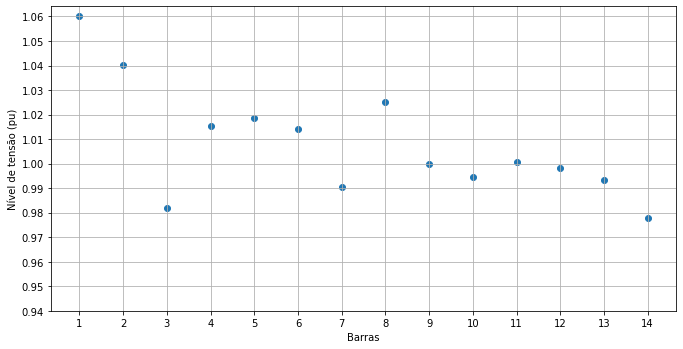

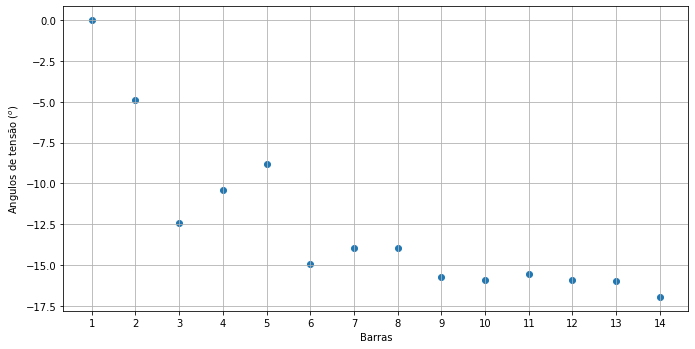

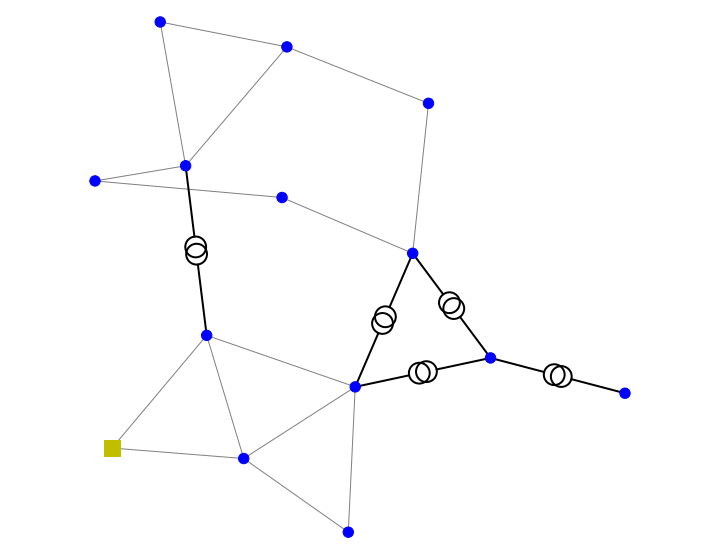

+-----------------------+----------------+
| Variáveis discretas   |   Valores (pu) |
|-----------------------+----------------|
| t_4-7                 |        1.0875  |
| t_4-9                 |        1.0125  |
| t_5-6                 |        0.99375 |
| b^sh_9                |        0.33993 |
+-----------------------+----------------+


In [25]:
v, ang, sis, table = sistema_viz(res, rede)

In [26]:
def alg_viz(resultados):
    '''
    Esta função gera gráficos da convergência do algoritmo GWO, mostrando a variação da função objetivo, 
    da função fitness e das penalizações ao longo das iterações;

    inputs:
        -> resultados: saída da função otimizar_alcateia.
    outputs:
        -> f_conv_plot: gráfico da convergência da função objetivo;
        -> fit_conv_plot: gráfico da convergência da função fitness;
        -> pen_conv_plot: gráfico da variação da soma das funções penalidade do lobo alfa a cada iteração.
    '''
    '''
    resultados = {'alfa': alfa_completo,
                 'f': curva_f,
                 'pen': curva_pen,
                 'fitness': curva_fitness,
                 'tempo': tempo_algoritmo}
    '''

    f_conv = resultados['f']
    fit_conv = resultados['fitness']
    pen_conv = resultados['pen']
    t_max = len(f_conv)

    #Iterações
    t = np.arange(t_max)

    #Gráfico da convergência da função objetivo
    f_conv_plot = plt.figure(figsize=(0.56*20,0.56*10))
    plt.xlabel('Iterações', figure = f_conv_plot)
    plt.ylabel(r'$f (V, \theta, t)$', figure = f_conv_plot)
    plt.plot(t, f_conv, figure = f_conv_plot)
    plt.grid(True, figure = f_conv_plot)
    plt.xticks(np.arange(t_max + int(t_max/10), step = int(t_max/10)), figure = f_conv_plot)
    
    #Gráfico da convergência da função fitness
    fit_conv_plot = plt.figure(figsize=(0.56*20,0.56*10))
    plt.xlabel('Iterações', figure = fit_conv_plot)
    plt.ylabel(r'$fitness (V, \theta, t, b^{sh})$', figure = fit_conv_plot)
    plt.plot(t, fit_conv, figure = fit_conv_plot)
    plt.grid(True, figure = fit_conv_plot)
    plt.xticks(np.arange(t_max + int(t_max/10), step = int(t_max/10)), figure = fit_conv_plot)

    #Gráfico da variação da soma das funções penalidade do lobo alfa a cada iteração.
    pen_conv_plot = plt.figure(figsize=(0.56*20,0.56*10))
    plt.xlabel('Iterações', figure = pen_conv_plot)
    plt.ylabel(r'$P_{sen}(t) + P_{sen}(b^{sh}) + P_V(V_{B_{CR}})$', figure = pen_conv_plot)
    plt.plot(t, pen_conv, figure = pen_conv_plot)
    plt.grid(True, figure = pen_conv_plot)
    plt.xticks(np.arange(t_max + int(t_max/10), step = int(t_max/10)), figure = pen_conv_plot)

    return f_conv_plot, fit_conv_plot, pen_conv_plot

(<Figure size 806.4x403.2 with 1 Axes>,
 <Figure size 806.4x403.2 with 1 Axes>,
 <Figure size 806.4x403.2 with 1 Axes>)

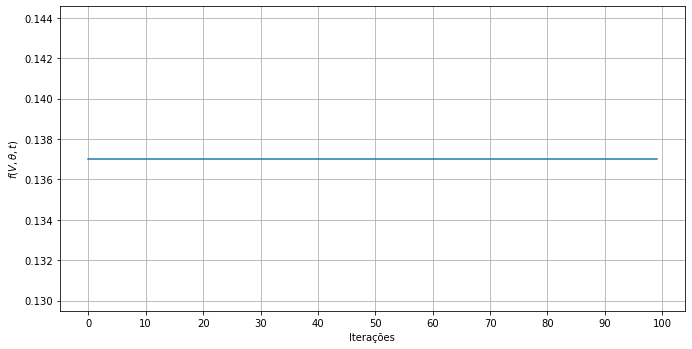

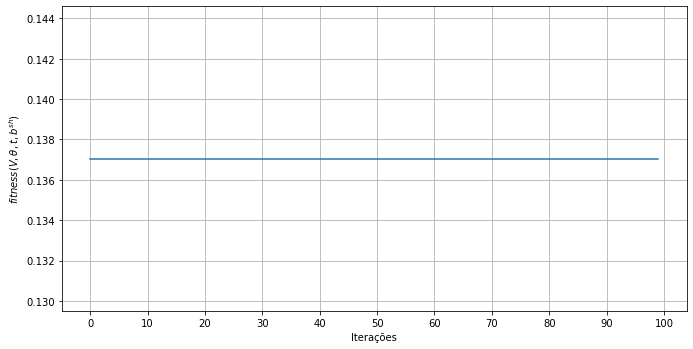

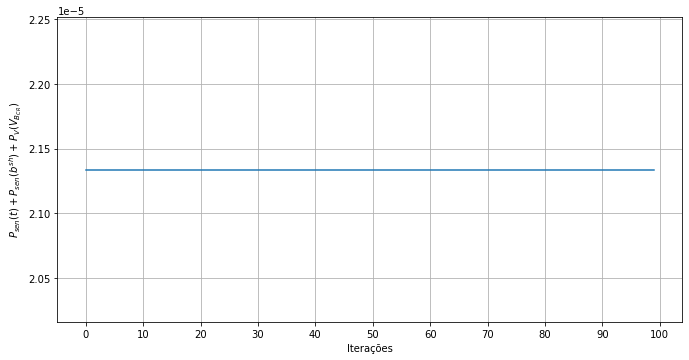

In [27]:
alg_viz(res)

In [28]:
def estatisticas(n_execucoes, n_lobos = 12, t_max = 100, lambd = 100.0):
    '''
    Executa o algoritmo GWO para solucionar o problema de FPOR com variáveis discretas 'n_execucoes' vezes.
    Dada a natureza estocástica do algoritmo meta-heurísitco GWO, cada execução do mesmo gera resultados diferentes.
    Assim sendo, é interessante executá-lo diversas vezes para obter a melhor solução possível.
    Além de fazer isso, esta função também realiza uma análise estatística dos resultados obtidos.

    inputs:
        n_execucoes: número desejado de execuções do algoritmo.
    
    outputs:
        melhor_alfa: melhor lobo alfa (melhor solução) obtido em todas as execuções;
        saída da função sistema_viz para a melhor solução obtida;
        saída da função alg_viz para a melhor solução obtida.
        tabela_estatistica: tabela contendo a análise estatística dos resultados.
    '''

    dim = ng + nt + ns

    #Listas para armazenar o melhor alfa e o resultado de cada execução
    alfas = []
    resultados = []

    parametros_rede = gerenciar_rede(rede)

    for execucao in range(n_execucoes):
        alcateia = inicializar_alcateia(n_lobos, rede, parametros_rede)
        _, resultado = otimizar_alcateia(alcateia, parametros_rede, t_max = t_max, verbose = False, lambd = lambd)
        alfas.append(resultado['alfa'])
        resultados.append(resultado)
    del execucao

    #Melhor solução (alfa) dentre todas as execuções:
    alfas = np.asarray(alfas)
    resultados = np.asarray(resultados)
   
    #Indice[0] é o índice do melhor alfa obtido
    indice = np.argmin(alfas, axis = 0)[-1]
    melhor_alfa = alfas[indice]
    melhor_resultado = resultados[indice]

    sistema_viz(melhor_resultado, rede)
    alg_viz(melhor_resultado)

    #Análise estatística
    f_medio = np.mean(alfas, axis = 0)[dim]
    f_max = np.amax(alfas, axis = 0)[dim]
    desvio_padrao = np.std(alfas, axis = 0)[dim]

    tabela_estatistica = [
        ['f_medio', f_medio],
        ['f_max', f_max],
        ['desvio_padrao', desvio_padrao]]

    tabela_estatistica = tabulate.tabulate(tabela_estatistica, headers = ['Estatísica', 'Valor'], tablefmt="psql")
    print(tabela_estatistica)

    # Dados do melhor alfa
    tabela_alfa = [
        ['t_max', t_max],
        ['f (MW)', melhor_alfa[ng+nt+ns]*100],
        ['Pen_v(V)', melhor_alfa[ng+nt+ns+1]/lambd],
        ['Pen_sen(t)', melhor_alfa[ng+nt+ns+2]/lambd],
        ['Pen_sen(b^sh)', melhor_alfa[ng+nt+ns+3]/lambd],
        ['Tempo (s)', melhor_resultado['tempo']]
    ]

    tabela_alfa = tabulate.tabulate(tabela_alfa, headers=['Dados', 'Valores'], tablefmt='psql')
    print(tabela_alfa)

    return melhor_alfa, tabela_estatistica, tabela_alfa, alfas, resultados, melhor_resultado

Iteração: 99. Melhor fitness: 0.13560542464256287. Melhor f: 0.13560542464256287. Tempo: 0.13303017616271973s
Tempo total de execução: 13.898037672042847s
Iteração: 99. Melhor fitness: 0.1362374871969223. Melhor f: 0.1362374871969223. Tempo: 0.12603759765625s
Tempo total de execução: 13.96617317199707s
Iteração: 99. Melhor fitness: 0.139218270778656. Melhor f: 0.139218270778656. Tempo: 0.12802815437316895s
Tempo total de execução: 13.326009750366211s
Iteração: 99. Melhor fitness: 0.13558374345302582. Melhor f: 0.13558374345302582. Tempo: 0.1270287036895752s
Tempo total de execução: 13.257003545761108s
Iteração: 99. Melhor fitness: 0.1352199763059616. Melhor f: 0.1352199763059616. Tempo: 0.1360313892364502s
Tempo total de execução: 13.38803243637085s
Iteração: 99. Melhor fitness: 0.13783273100852966. Melhor f: 0.13783273100852966. Tempo: 0.13002920150756836s
Tempo total de execução: 13.395034313201904s
Iteração: 99. Melhor fitness: 0.13619796931743622. Melhor f: 0.13604550063610077. Tem

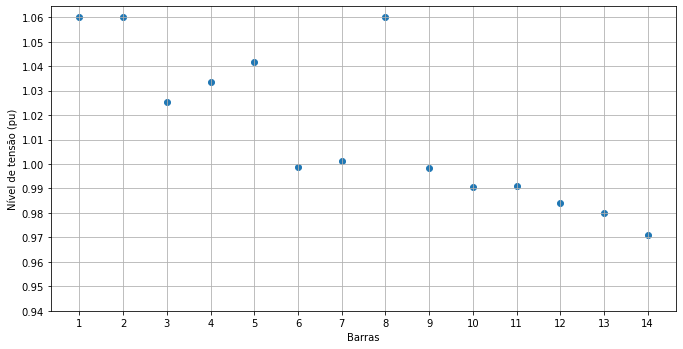

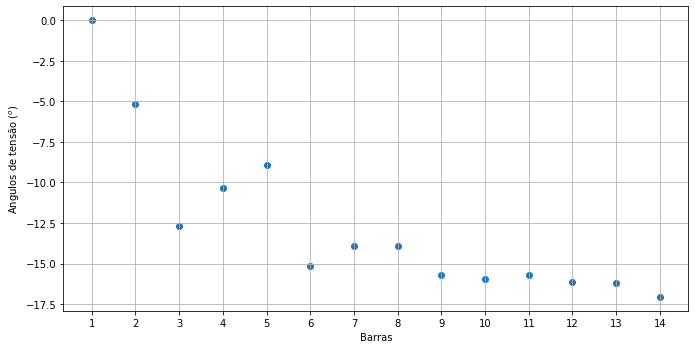

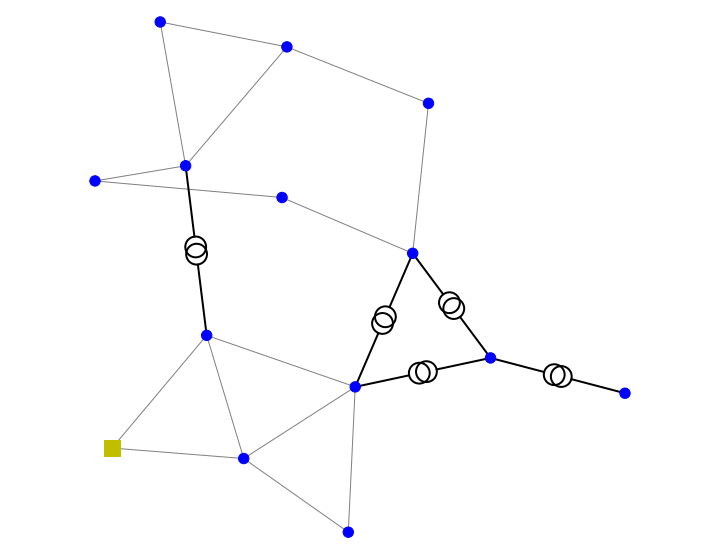

+-----------------------+----------------+
| Variáveis discretas   |   Valores (pu) |
|-----------------------+----------------|
| t_4-7                 |            1.1 |
| t_4-9                 |            0.9 |
| t_5-6                 |            1.1 |
| b^sh_9                |            0   |
+-----------------------+----------------+
+---------------+------------+
| Estatísica    |      Valor |
|---------------+------------|
| f_medio       | 0.137905   |
| f_max         | 0.143964   |
| desvio_padrao | 0.00187335 |
+---------------+------------+
+---------------+---------------+
| Dados         |       Valores |
|---------------+---------------|
| t_max         | 100           |
| f (MW)        |  13.522       |
| Pen_v(V)      |   3.27418e-15 |
| Pen_sen(t)    |   0           |
| Pen_sen(b^sh) |   0           |
| Tempo (s)     |  13.388       |
+---------------+---------------+


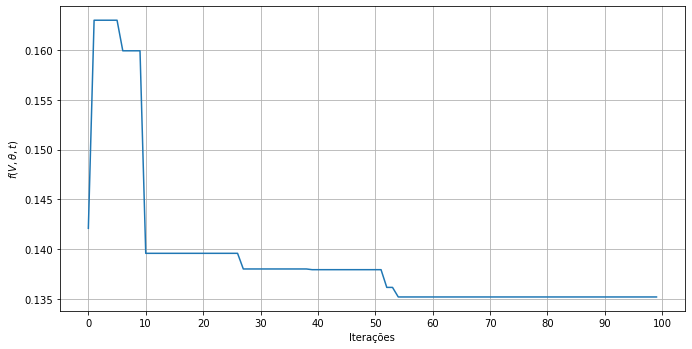

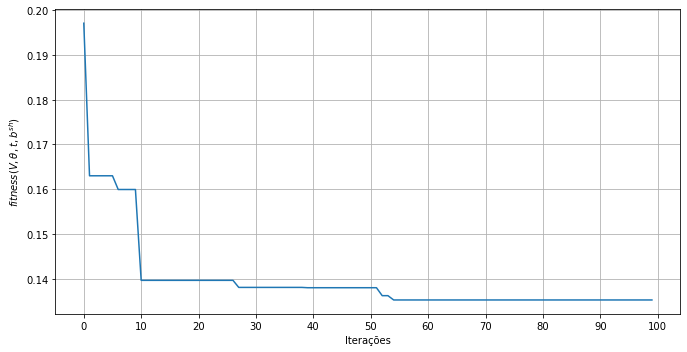

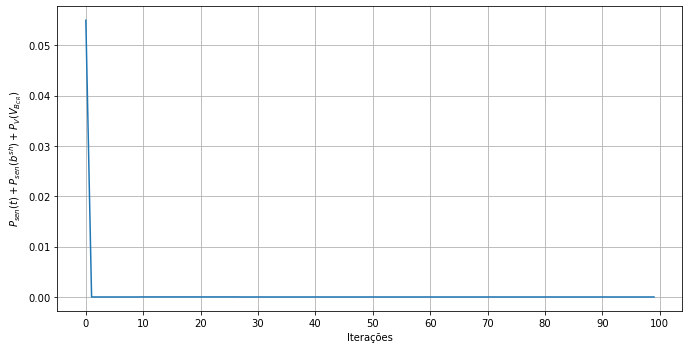

In [30]:
rede = case14()

#Executar o fluxo de carga uma primeira vez acelera os cálculos posteriores
pp.runpp(rede, algorithm = 'nr', numba = True)

parametros_rede = gerenciar_rede(rede)

melhor_alfa, t_stats, t_alfa, alfas, resultados, melhor_resultado = estatisticas(n_execucoes = 50, n_lobos = 12, t_max = 100, lambd = 100.0)